# Assignment 5: Statistical Analysis (30 pt)

Use as many Python and markdown cells per question as you deem necessary. **DO NOT SUBMIT CODE THAT DOES NOT RUN.** You will lose points for code that throws errors. 

Questions 1 and 2 will use data describing various wetlands, intertidal zones, and ocean conditions in the United States from 1972-2015. This data has been adapted from [publicly available data from NASA](https://daac.ornl.gov/NACP/guides/Tidal_Wetland_Estuaries_Data.html). Note that this file uses the value `-9999` to denote missing data. This file's path is `data/tidal_wetland_estuaries.csv`.

Question 3 will be using time series data describing the proportion of electricity produced by coal in high income countries from [the World Bank](https://data.worldbank.org/indicator/EG.ELC.COAL.ZS). The path to the file is `data/coal-production.csv`.


## Question 1: t-tests (10 pt)

Using the data from `tidal_wetland_estuaries.csv`, test the hypothesis that soil organic carbon density (column name: `soc_density`) is **larger** in the East coast than the West coast with a t-test. Interpret the t-test. (5 pt)

Defend your choice of which type of t-test you used (3 pt).

Do the data meet the requirement for normal data? Why or why not? (2 pt) 

### **Q1: Mini Data Pre-Process**
First I wanted to clean up the data to get rid of missing values, separate the East and West coast into separate data frames that I could compare them, and I also created variables for the columns we would be comparing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

tidal = pd.read_csv('/Users/delre/assignment-5/data/tidal_wetland_estuaries.csv')

tidaldata = tidal.replace(-9999, np.NaN)
missing = tidaldata.isnull()
#print(tidaldata)
#print(tidaldata[missing])

ec_soil = tidaldata.loc[tidaldata['coast']=='EAST',:].reset_index(drop=True)
wc_soil = tidaldata.loc[tidaldata['coast']=='WEST',:].reset_index(drop=True)

#print(wc_soil)
#print(ec_soil)

ec_soc_density = ec_soil['soc_density']
wc_soc_density = wc_soil['soc_density']

#print(ec_soc_density)
#print(wc_soc_density)

### **Q1: Checking for Normal Data**
I made some histograms to see if the data was normally distributed before running my tests since T-tests assume normal data

0.07757692307692311 is the mean value for East Coast Soil Density
0.077 is the median value for East Coast soil density


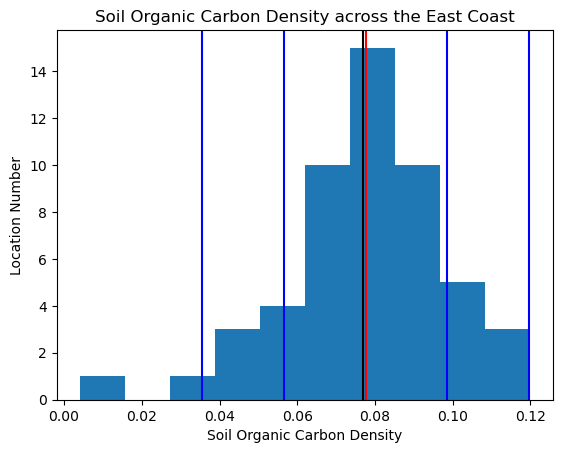

This histogram shows the east coast soil density data is normally distributed
The mean and median are about equal and the data is distributed about equally around the mean


In [3]:
ec_mean_soc_density = ec_soc_density.mean()
print(ec_mean_soc_density, 'is the mean value for East Coast Soil Density')

ec_median_soc_density = ec_soc_density.median()
print(ec_median_soc_density, 'is the median value for East Coast soil density')

ec_std_soc_density = np.std(ec_soc_density)

plt.hist(ec_soc_density)
plt.title('Soil Organic Carbon Density across the East Coast')
plt.xlabel('Soil Organic Carbon Density')
plt.ylabel('Location Number')
plt.axvline(x=ec_mean_soc_density, color="red")
plt.axvline(x=ec_median_soc_density, color="black")
plt.axvline(x=ec_mean_soc_density-ec_std_soc_density, color="blue")
plt.axvline(x=ec_mean_soc_density+ec_std_soc_density, color="blue")
plt.axvline(x=ec_mean_soc_density-2*ec_std_soc_density, color="blue")
plt.axvline(x=ec_mean_soc_density+2*ec_std_soc_density, color="blue")
plt.show()
print('This histogram shows the east coast soil density data is normally distributed')
print('The mean and median are about equal and the data is distributed about equally around the mean')

0.03779310344827588 is the mean value for West Coast Soil Density
0.044 is the median value for West Coast soil density


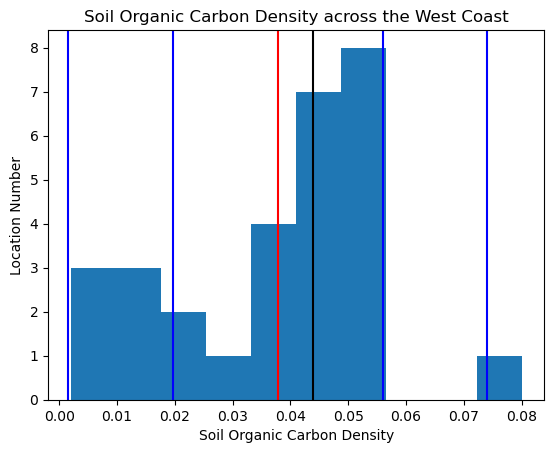

This histogram shows the West coast soil density data is somewhat normally distributed


In [4]:
wc_mean_soc_density = wc_soc_density.mean()
print(wc_mean_soc_density, 'is the mean value for West Coast Soil Density')

wc_median_soc_density = wc_soc_density.median()
print(wc_median_soc_density, 'is the median value for West Coast soil density')

wc_std_soc_density = np.std(wc_soc_density)

plt.hist(wc_soc_density)
plt.title('Soil Organic Carbon Density across the West Coast')
plt.xlabel('Soil Organic Carbon Density')
plt.ylabel('Location Number')
plt.axvline(x=wc_mean_soc_density, color="red")
plt.axvline(x=wc_median_soc_density, color="black")
plt.axvline(x=wc_mean_soc_density-wc_std_soc_density, color="blue")
plt.axvline(x=wc_mean_soc_density+wc_std_soc_density, color="blue")
plt.axvline(x=wc_mean_soc_density-2*wc_std_soc_density, color="blue")
plt.axvline(x=wc_mean_soc_density+2*wc_std_soc_density, color="blue")
plt.show()
print('This histogram shows the West coast soil density data is somewhat normally distributed')

While the West Coast Soil data does not have a nice bell shape like the East Coast data, it is still centralized around the median, which is close to the mean. About 2/3 of the data is within one standard deviation of the mean and about 95% of data is within two standard deviations of the mean, so it can still be considered normally distributed.

### **Q1: Comparing datasets**

The next step in determining the appropriate T-test was to check whether both datasets had equal amounts of information:

In [5]:
print(ec_soc_density.shape)
print(wc_soc_density.shape)

print('A paired T-Test is impossible because each sample has a different amount of data')

(52,)
(29,)
A paired T-Test is impossible because each sample has a different amount of data


### **Q1: T-Test**
The hypothesis that soil organic carbon density is **larger** in the east coast than the west coast compares two different groups of data -- one representing soil collected on the east coast, and one on the other side of the country on the west coast.

**A 2-sample T test is the appropriate way to test this hypothesis. A 2-sample T test will compare the mean organic carbon density of soil on the two separate coasts.** 

A 1-sample T test would not make sense because East and West coast data are different samples; a paired T test would be impossible because the samples are different sizes, and it would not make sense because we are not trying to compare two variables for the same sample of data

In [6]:
from scipy.stats import ttest_ind

ttest_ind(ec_soc_density,wc_soc_density, alternative='greater',equal_var=True)

Ttest_indResult(statistic=8.45031778669312, pvalue=5.765284478012742e-13)

### **Q1: Interpreting the Results**
**The t-test supports the hypothesis that soil organic carbon density is larger in the East coast than the West coast.**

The p value is tiny (negative 13 exponent) -- far less than the .05 necessary to reject the null hypothesis (which assumes that soil organic carbon density is not larger in the East coast than the West coast).

When the t-value ('statistic') is close to 0, that indicates there is little difference between the means of the two samples being compared. In these cases, the null hypothesis (which assumes that the means of the two samples are equal) cannot be rejected. However in this case, the t-value ('statistic') is relatively high (8), meaning that the two samples have a large difference between their mean relative to their group variances, and by extention, granting greater confidence in the test results.

## Question 2

Using the data from `tidal_wetland_estuaries.csv`, create a linear model to predict mean ocean salinity (column name: `ocean_salinity_mean`) from other environmental factors. (2 pt)

Create a model with a high R-squared value (> 0.80). All coefficients should be significant, and none should have VIF values above 5.0. (4 pt)

Interpret the summary of the model, focusing on the R-squared value and the regression coefficients. (3 pt)

Make diagnostic plots to ensure your data meets the assumptions of linear regression. The necessary functions have been imported for you. (1 pt).

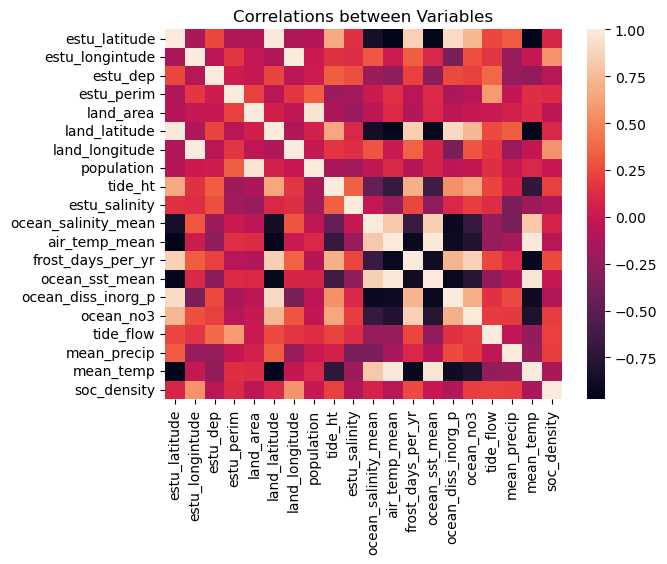

Index(['name', 'coast', 'estu_latitude', 'estu_longintude', 'estu_dep',
       'estu_perim', 'land_area', 'land_latitude', 'land_longitude',
       'population', 'tide_ht', 'estu_salinity', 'ocean_salinity_mean',
       'air_temp_mean', 'frost_days_per_yr', 'ocean_sst_mean',
       'ocean_diss_inorg_p', 'ocean_no3', 'tide_flow', 'mean_precip',
       'mean_temp', 'soc_density'],
      dtype='object')


In [7]:
#reminder to myself
tidal = pd.read_csv('/Users/delre/assignment-5/data/tidal_wetland_estuaries.csv')
tidaldata = tidal.replace(-9999, np.NaN)

correlations = tidaldata.corr()

sns.heatmap(correlations)
plt.xticks(rotation=90)
plt.title('Correlations between Variables')
plt.show()

print(tidaldata.columns)

**Q2: Linear model to predict mean ocean salinity from other environmental factors**

In [8]:
from utils import Linear_Reg_Diagnostic # do not change!
import statsmodels.formula.api as smf

model = smf.ols(formula="ocean_salinity_mean ~ soc_density + tide_flow + mean_precip", data=tidaldata).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ocean_salinity_mean   R-squared:                       0.230
Model:                             OLS   Adj. R-squared:                  0.209
Method:                  Least Squares   F-statistic:                     10.97
Date:                 Mon, 08 May 2023   Prob (F-statistic):           2.32e-06
Time:                         15:59:09   Log-Likelihood:                -202.43
No. Observations:                  114   AIC:                             412.9
Df Residuals:                      110   BIC:                             423.8
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      34.9070      0.478     72.968      0.000      33.959      35.855
soc_density    11.8924      5.077      2.342      0.021       1.831      21.954
tide_flow   -2.355e-10   7.08e-11     -3.326      0.001   -3.76e-10   -9.52e-11
mean_precip    -0.0015      0.000     -4.885      0.000      -0.002      -0.001
==============================================================================
Omnibus:                       24.891   Durbin-Watson:                   0.252
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.172
Skew:                           0.383   Prob(JB):                       0.0168
Kurtosis:                       1.936   Cond. No.                     8.32e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.32e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Q2: Model with high r squared value**

In [9]:
model_highr2 = smf.ols(formula="ocean_salinity_mean ~ ocean_diss_inorg_p + ocean_no3 + tide_flow + mean_precip", data=tidaldata).fit()
model_highr2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ocean_salinity_mean   R-squared:                       0.868
Model:                             OLS   Adj. R-squared:                  0.863
Method:                  Least Squares   F-statistic:                     179.6
Date:                 Mon, 08 May 2023   Prob (F-statistic):           5.14e-47
Time:                         15:59:09   Log-Likelihood:                -101.82
No. Observations:                  114   AIC:                             213.6
Df Residuals:                      109   BIC:                             227.3
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             37.0513      0.193    192.245      0.000      36.669      37.433
ocean_diss_inorg_p    -7.4928      0.455    -16.460      0.000      -8.395      -6.591
ocean_no3             -0.1019      0.065     -1.574      0.118      -0.230       0.026
tide_flow          -7.753e-11   2.93e-11     -2.644      0.009   -1.36e-10   -1.94e-11
mean_precip           -0.0005      0.000     -4.172      0.000      -0.001      -0.000
==============================================================================
Omnibus:                        0.314   Durbin-Watson:                   0.353
Prob(Omnibus):                  0.855   Jarque-Bera (JB):                0.482
Skew:                           0.070   Prob(JB):                        0.786
Kurtosis:                       2.714   Cond. No.                     1.82e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.82e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
lowvif = Linear_Reg_Diagnostic(model_highr2)
lowvif.vif_table()

             Features  VIF Factor
3           tide_flow        1.05
4         mean_precip        1.08
2           ocean_no3        1.97
1  ocean_diss_inorg_p        2.00
0           Intercept       11.59


**Q2: Interpreting model_highr2**

model_highr2 has a r squared value of 0.868, which means the model explains about 86.8% of the variability in the dependent variable (ocean_salinity_mean). R squared values range from 0 (which would indicate that the model does not explain the variance between the independent and dependent variables) to 1 (which would imply a full explanation based on the model).

The regression coefficients indicate how much each independent variable affects the dependent variable. With a small coefficient of -7.753e-11, the model indicates that 'tide_flow' has a weak relationship with ocean salinity. In contrast, ocean_diss_inorg_p has a coefficient of -7.4928, so we would expect to see salinity change -7.4928 for 1 change of ocean_diss_inorg_p holding other variables constant (a strong relationship).

**Q2: Diagnostic plots**

<AxesSubplot:title={'center':'Residuals vs Leverage'}, xlabel='Leverage', ylabel='Standardized Residuals'>

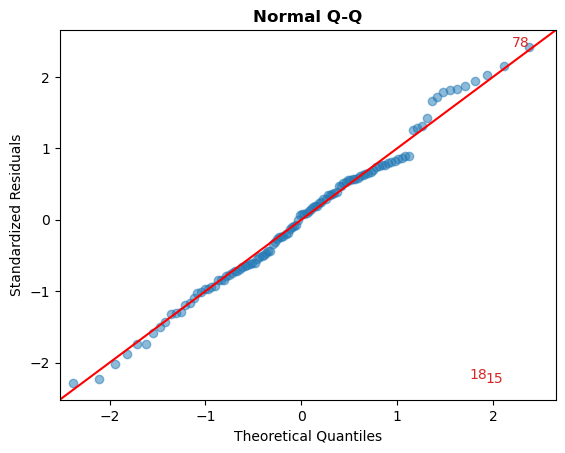

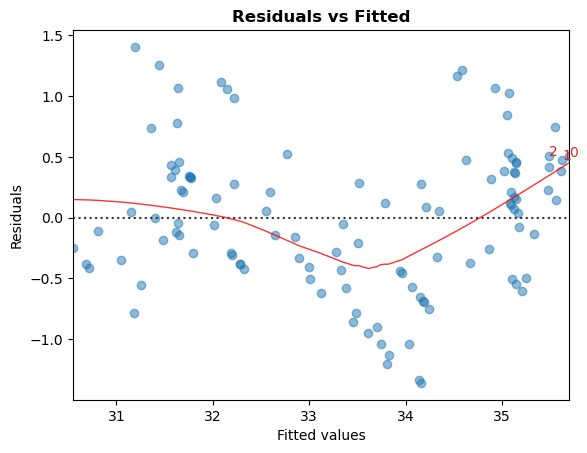

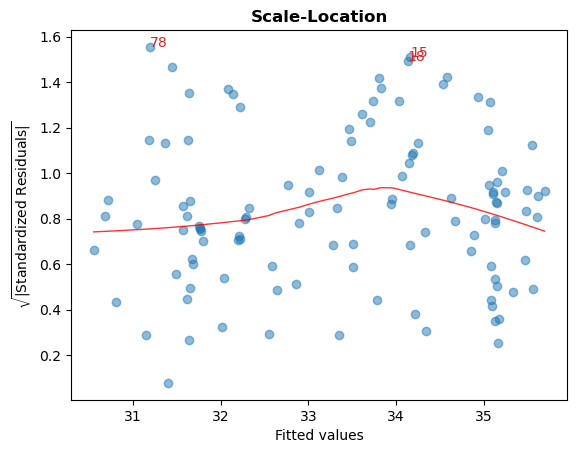

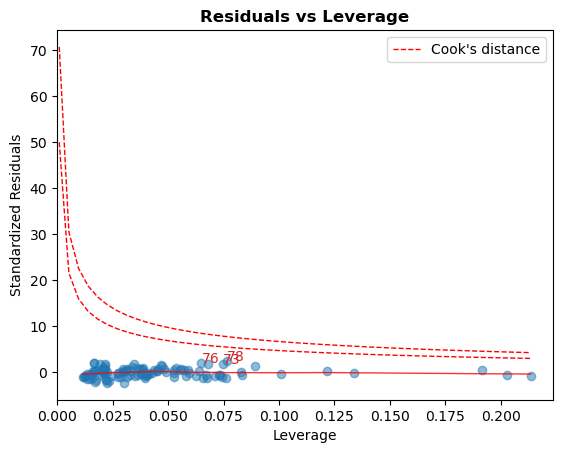

In [11]:
diagnostic = Linear_Reg_Diagnostic(model_highr2)
diagnostic.qq_plot()
diagnostic.residual_plot()
diagnostic.scale_location_plot()
diagnostic.leverage_plot()

## Question 3 

Using the `coal-production.csv` data, model the proportion of electricity produced with coal in high income countries over time with an ARIMA model. 

Process the data to be useable for time series analysis. (2 pt)

Display your data. Does it appear to have a trend? If so, describe the trend. (1 pt)

Test for stationarity. (1 pt)

Make an ARIMA model of the time series, either by manually testing different types, or with an auto-ARIMA. What type of ARIMA model was found to be the best fit? (2 pt)

Visualize the fitted values of the ARIMA model, being sure to label each line. (2 pt)

Make a forecast for 25 years after the conclusion of the time series and visualize with observed and fitted values. (2 pt)

In [12]:
coal = pd.read_csv('/Users/delre/assignment-5/data/coal-production.csv')
#print(coal)
coal.head()

,year,electricity_prod
0,1960,45.904345
1,1961,45.730794
2,1962,46.411172
3,1963,46.599523
4,1964,46.102588


**Q3: Process the data to make it usable for time series analysis**

In [13]:
coal['year'] = pd.to_datetime(coal['year'], format='%Y')
coal = coal.set_index('year').sort_index()
coal.head()

,electricity_prod
year,
1960-01-01,45.904345
1961-01-01,45.730794
1962-01-01,46.411172
1963-01-01,46.599523
1964-01-01,46.102588


**Q3: Displaying the data**

Text(0.5, 1.0, 'Percent of Electricity Produced By Coal 1960-2015')

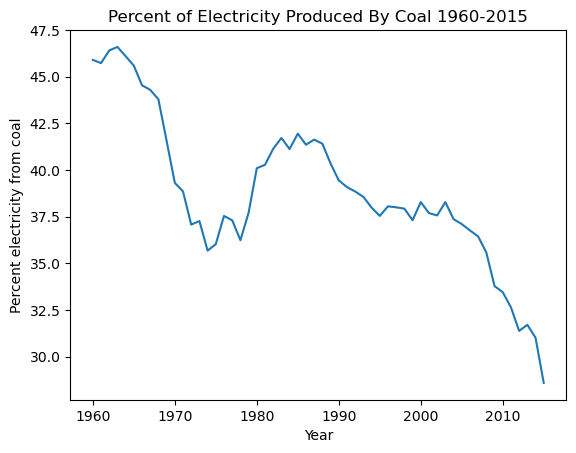

In [14]:
fig, ax = plt.subplots()
ax.plot(coal['electricity_prod'])
ax.set_xlabel('Year')
ax.set_ylabel('Percent electricity from coal')
ax.set_title('Percent of Electricity Produced By Coal 1960-2015')

**Q3: Trends**

The data appears to show a downward or negative trend indicating a potential shift away from using coal for energy production.

**Q3: Testing for Stationarity**

In [15]:
from statsmodels.tsa.stattools import adfuller

adfuller(coal.values.flatten())

def adf_print(time_series):
    adf_output = adfuller(time_series)
    stat = adf_output[0]
    pval = adf_output[1]
    print('ADF Statistic:', stat)
    print('p-value:', pval)
    return None

adf_print(coal)

ADF Statistic: 1.8721544326758233
p-value: 0.9984818799941668


The large p value (0.998, far above 0.5) indicates that we can reject the null hypothesis (that the time series is stationary). In short: the data is NOT stationary.

**Q3: ARIMA Models**

In [20]:
from pmdarima import auto_arima

auto_arima_coal = auto_arima(coal['electricity_prod'])
auto_arima_coal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   56
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -71.684
Date:                Mon, 08 May 2023   AIC                            149.368
Time:                        16:18:28   BIC                            155.390
Sample:                    01-01-1960   HQIC                           151.697
                         - 01-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8478      0.140      6.074      0.000       0.574       1.121
ma.L1         -0.6020      0.230     -2.622      0.009      -1.052      -0.152
sigma2         0.7894      0.171      4.604      0.000       0.453       1.125
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 1.33
Prob(Q):                              0.68   Prob(JB):                         0.51
Heteroskedasticity (H):               0.72   Skew:                             0.36
Prob(H) (two-sided):                  0.49   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The results show (1 1 1) to be the model with the best fit (meaning best fit for AR, I, MA are all 1)

**Q3: ARIMA visualization**

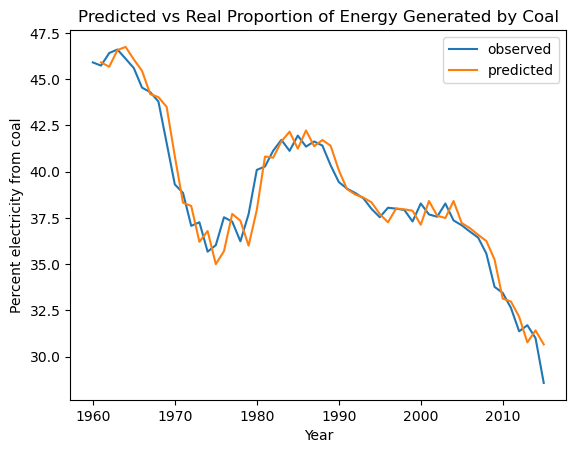

In [27]:
in_sample_coal = auto_arima_coal.predict_in_sample()

fig, ax = plt.subplots()
ax.plot(coal, label='observed')
ax.plot(in_sample_coal[1:], label='predicted')
ax.set_xlabel('Year')
ax.set_ylabel('Percent electricity from coal')
ax.set_title('Predicted vs Real Proportion of Energy Generated by Coal')
ax.legend()

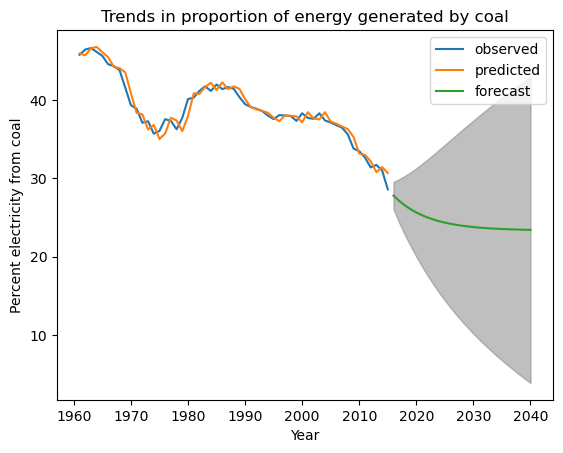

In [32]:
forecast, ci = auto_arima_model.predict(25, return_conf_int=True)

fig, ax = plt.subplots()
ax.plot(coal[1:], label='observed')
ax.plot(in_sample_coal[1:], label='predicted')
ax.plot(forecast, label='forecast')
ax.fill_between(forecast.index, ci[:,0], ci[:,1], color = 'gray', alpha=0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Percent electricity from coal')
ax.set_title('Trends in proportion of energy generated by coal')
ax.legend()